# Exploring the Open SGID: A Brief Tutorial Using Open Source Python Tools
The accompanying Python Notebook for this blog post can be found [here on Google Colab](https://colab.research.google.com/drive/13evGMipBC0lqFStboTkZmtJji-zvovs0#scrollTo=tEkj3tFP-ca2).

## The Open SGID
The introduction of the [Open SGID](https://gis.utah.gov/introducing-open-sgid/) has opened the door for new ways to explore Utah's GIS data.  In the past, a user would typically have gone to the AGRC web page to find the data they were looking for and download it in shapefile or file geodatabase format--and this can still be done today.  Now that AGRC has leveraged the [Open Data](https://opendata.gis.utah.gov/) platform, there are more options for users to access geospatial data in their preferred way.  Data can now be streamed into a GIS client via web services or downloaded in even more formats (GeoJSON, KML, CSV).  But another exciting offering is the recently launched Open SGID, which is a cloud-hosted PostgreSQL PostGIS database that anyone can connect to.  With nightly automated updates, tapping into the Open SGID means you'll have a living connection to the freshest SGID data available.
The Open SGID also creates an opportunity to pull in data and perform analysis using only open source Python libraries.  With this route, you don't need to worry about paying for licensed software or even installing GIS desktop software at all.  And if you use a cloud-hosted Jupyter notebook--like Google Colab--you don't even have to install Python on your computer (or tablet or chromebook)!



## Python Notebook and Libraries
The rest of this blog will walk you through a few examples of how easy it can be to pull SGID data into Python to perform analysis or create simple maps.  These basic building blocks, combined with a little gumption and googling, can put you well on your way to performing whatever analysis you desire.  A link to the Jupyter notebook in Google Colab is also included, so you can run the code yourself and build upon it.  Following Python libraries will be used in this tutorial:

*   [Psycopg2](https://www.psycopg.org/) - A PostgreSQL/PostGIS client for Python
*   [GeoPandas](https://geopandas.org/) - An open source Python project for working with geospatial data
  * Extends the popular [Pandas](https://pandas.pydata.org/) library to geospatial data
* [Matplotlib](https://matplotlib.org/) - a plotting and visualization library for Python

(Note: some of the querying and filtering in these examples can be done entirely in SQL, but GeoPandas is used to demonstrate its capabilities)


## Install and Import Needed Python Libraries
In the two code blocks, called cells, we install the python libraries that aren't pre-installed (geopandas and psycopg2) and then import the needed libraries so they can be used in the script (geopandas, matplotlib, psycopg2).

In [0]:
# Install the libraries you'll need
!pip install geopandas
!pip install psycopg2

     |████████████████████████████████| 931kB 7.8MB/s 
     |████████████████████████████████| 10.9MB 28.8MB/s 
     |████████████████████████████████| 14.7MB 260kB/s 


In [0]:
# Import the libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import psycopg2

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## County Boundaries in Utah
We'll start with a very simple example where we pull county boundaries from the Open SGID using the psycopg2 database client for Postgres and plot them with a basic map.  First, we create a connection object that will hold the necessary arguments for the Postgres connection (database, user, password, and host).  Second, we build a SQL query that will be used to specify the data layer we want to retrieve.  Third, we use a GeoPandas method to read data from PostGIS, supplying it with our SQL query, connection information, and the field we will be using as the geometry column--this is typically the 'shape' field for the Open SGID.  Once we have our spatial data, we can create a simple plot of it with the GeoPandas '.plot()' method, which uses matplotlib behind the scenes.

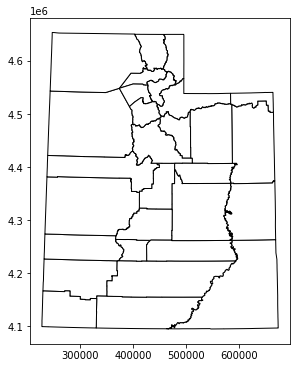

In [0]:
# Postgres database connection information
con = psycopg2.connect(database="opensgid", user="agrc", password="agrc",
    host="opensgid.agrc.utah.gov")

# Simple query to grab and plot Utah counties
sql = "select * from opensgid.boundaries.county_boundaries"
counties = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='shape')

counties.plot(figsize=(10, 6), color='white', edgecolor='black')

## Davis County Address Points by Zip Code
For the second example, we'll do something a little more colorful by plotting address points in Davis county, colored by zip code.  We'll need to create two data layers, one for the address points and one for the county boundary.  This time we'll also expand our SQL query by adding a 'where clause' to filter the address points down to just those in Davis county (`countyid = '49011'`) and select just Davis county's boundary (`name = 'DAVIS'`).  Our plot gets a little more complex, too, as we begin to customize the appearance a little more.  We create figure and axis objects that can provide more control over the plot's appearance using matplotlib.  Then, we add each layer to the plot, specifying the axis that we want to use, and and different color and size properties.  For the address points, we plot the colors based on the zip code (`column='zipcode'`), assign a colormap (`cmap='jet'`), and add a legend by specifying the title and location.  Finally, we can add a title to the plot (`plt.title('Davis County Address Points')`) and send it to the display with `plt.show()`.  [GeoPandas](https://geopandas.org/mapping.html) and [Matplotlib](https://matplotlib.org/tutorials/introductory/pyplot.html) both provide documentation on how to customize plots.

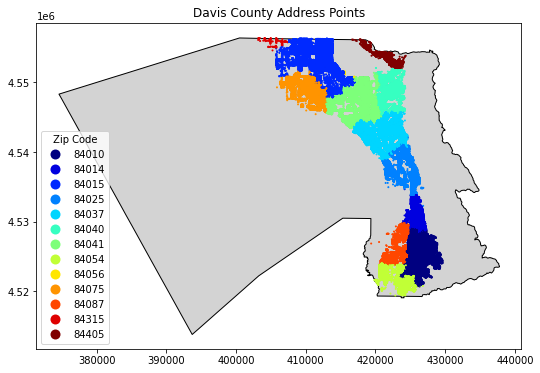

In [0]:
# Davis County address points by zip code
sql_addpts = "select * from opensgid.location.address_points where countyid = '49011'"
addpts = gpd.GeoDataFrame.from_postgis(sql_addpts, con, geom_col='shape')

sql_davis = "select * from opensgid.boundaries.county_boundaries where name = 'DAVIS'"
davis = gpd.GeoDataFrame.from_postgis(sql_davis, con, geom_col='shape')

# Plot address points symbolized by zip code
fig, ax = plt.subplots(figsize=(10, 6))
davis.plot(ax=ax, color='lightgray', edgecolor='black')
addpts.plot(ax=ax, column='zipcode', cmap='jet', markersize=1, legend=True,
            legend_kwds={'title': 'Zip Code',
                         'loc': 'lower left'})
plt.title('Davis County Address Points')
plt.show()

## Utah Faults Longer than One Mile
In the third example, we'll demonstrate the subsetting capabilities of Pandas/GeoPandas to find and plot fault lines in Utah that are longer than 1 mile (1609.34 meters).  First, we'll specify the layer we want to work with in our SQL query.  Second, we'll create a subset of all the faults (called 'long_faults') by selecting those where the 'shape' field has a length greater than 1609.34 meters.  We use `.copy()` at the end of this line of code to prevent a 'chained assignment' warning in Pandas.  Next, we'll calculate a new field in this subset that converts the length into miles, for easier interpretation.  Finally, we plot the counties and faults longer than 1 mile, colored by length.  Note that the syntax for the legend is a little different now that we are plotting a continuous variable (lengths a floating point) rather than a discrete variable (zipcodes as strings).  We also specify the starting and ending ranges for the colorbar (`vmin` and `vmax`).

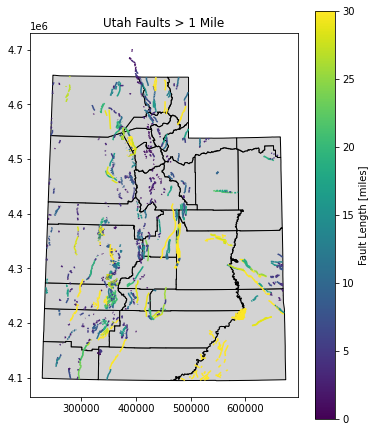

In [0]:
# Utah faults longer than 1 mile
sql_faults = "select * from opensgid.geoscience.quaternary_faults"
faults = gpd.GeoDataFrame.from_postgis(sql_faults, con, geom_col='shape')

# Filter down to faults longer than 1 mile, create 'length_mi' column
long_faults = faults[faults['shape'].length > 1609.34].copy()
long_faults['length_mi'] = long_faults['shape'].length/1609.34

# Plot faults symbolized by length of the fault
fig, ax = plt.subplots(figsize=(6, 10))
counties.plot(ax=ax, color='lightgray', edgecolor='black')
long_faults.plot(ax=ax, column='length_mi', cmap='viridis', vmin=0, vmax=30, legend=True,
                 legend_kwds={'label': 'Fault Length [miles]', 'shrink': 0.75})
plt.title('Utah Faults > 1 Mile')
plt.show()

## Libraries in State Senate District 24
For the fourth example, we'll plot public libraries within State Senate district 24 by using a spatial operation, which is really where GeoPandas shines and set itself apart from non-spatial tools.  We start by selecting our data layers (hopefully the syntax is getting familiar now) with SQL queries and reading them in with GeoPandas.  Next, we subset the senate districts down to just district 24 using Pandas square bracket `[]` notation.  Then, we subset the libraries data set by getting the libraries (and their geometry) that are within district 24.  Finally, we plot all districts, our selected district (24), and all libraries that fall within our selected district.

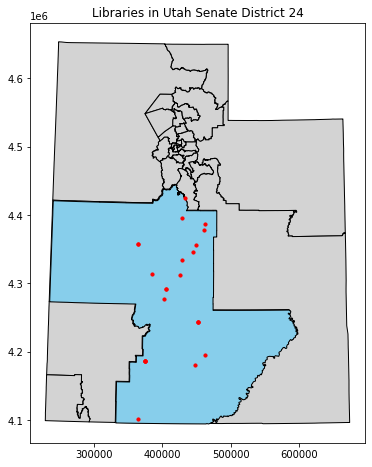

In [0]:
# Utah Libraries in Senate District 24
sql_sen = "select * from opensgid.political.senate_districts_2012"
sen_districts = gpd.GeoDataFrame.from_postgis(sql_sen, con, geom_col='shape')

sql_lib = "select * from opensgid.society.libraries"
libraries = gpd.GeoDataFrame.from_postgis(sql_lib, con, geom_col='shape')

# Filter down to district 24 and select libraries within the district
dist_24 = sen_districts.loc[sen_districts['dist'] == 24]
lib_24 = libraries[libraries.within(dist_24.unary_union)]

# Plot senate districts and libraries
fig, ax = plt.subplots(figsize=(6, 10))
sen_districts.plot(ax=ax, color='lightgray', edgecolor='black')
dist_24.plot(ax=ax, color='skyblue', edgecolor='black')
lib_24.plot(ax=ax, color='red', markersize=10)
plt.title('Libraries in Utah Senate District 24')
plt.show()

That's it!  We've now gone over a few different ways to gather and analyze data from the Open SGID with the psycopg2 and geopandas libraries.  Hopefully this brief tutorial was helpful and will spark your interest in both the Open SGID and using open source Python tools.